# Pipeline for High-z Radio Galaxies 13: Study behaviour of scores on radio flux

## Introduction

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.ndimage import gaussian_filter
# import sklearn.pipeline
import colorcet as cc
# from pycaret import classification as pyc
# from pycaret import regression as pyr
from joblib import dump, load
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

In [4]:
def radio_lum(flux, z, alpha):  # Output in W Hz-1
    lum_dist = cosmo.luminosity_distance(z).to(u.m)
    num      = 4 * np.pi * flux.to(u.Jy) * lum_dist**2
    denom    = (1 + z)**(alpha +1)
    return (num/denom).to(u.W / u.Hz)

In [5]:
def clean_and_smooth_matrix(matrix, sigma=0.9):
    matrix[~np.isfinite(matrix)] = 0
    matrix_smooth = gaussian_filter(matrix, sigma=0.9)
    matrix_smooth[~np.isfinite(matrix_smooth)] = 0
    return matrix_smooth

In [6]:
def pad_matrix_zeros(matrix, xedges, yedges):  # Pads matrices and creates centred edges
    x_centres = 0.5 * (xedges[:-1] + xedges[1:])
    y_centres = 0.5 * (yedges[:-1] + yedges[1:])
    matrix    = np.pad(matrix, ((1, 1), (1, 1)), mode='constant', constant_values=(0,))
    x_centres = np.pad(x_centres, (1, 1), mode='constant', constant_values=(xedges[0], xedges[-1]))
    y_centres = np.pad(y_centres, (1, 1), mode='constant', constant_values=(yedges[0], yedges[-1]))
    return matrix, x_centres, y_centres

In [7]:
def fmt(x):
    x = x * 100.
    x = 100. - x
    s = f'{x:.2f}'
    if s.endswith('0'):
        s = f'{x:.0f}'
    return rf'${s} \%$' if plt.rcParams['text.usetex'] else f'{s} %'

In [8]:
def cut_rgb_val(val):
    if val < 0.0:
        return 0.0
    if val > 1.0:
        return 1.0
    else:
        return val

In [9]:
colour_hex_rGal = '#1E88E5'
colour_hex_rAGN = '#D32F2F'

colour_rGal = mcolors.to_rgba(colour_hex_rGal)
colour_rAGN = mcolors.to_rgba(colour_hex_rAGN)

colour_rGal_rgb = mcolors.to_rgb(colour_hex_rGal)
colour_rAGN_rgb = mcolors.to_rgb(colour_hex_rAGN)

colour_rGal_shade = list(colour_rGal)
colour_rAGN_shade = list(colour_rAGN)

colour_rGal_shade[3] = 0.6
colour_rAGN_shade[3] = 0.6

colour_rGal_shade = tuple(colour_rGal_shade)
colour_rAGN_shade = tuple(colour_rAGN_shade)

In [10]:
colour_rGal_rgb_darker = list(colour_rGal_rgb)
colour_rAGN_rgb_darker = list(colour_rAGN_rgb)

colour_rGal_rgb_darker = list([value * 0.7 for value in colour_rGal_rgb_darker])
colour_rAGN_rgb_darker = list([value * 0.7 for value in colour_rAGN_rgb_darker])

colour_rGal_rgb_bright = list([cut_rgb_val(value * 1.5) for value in list(colour_rGal_rgb)])
colour_rAGN_rgb_bright = list([cut_rgb_val(value * 1.5) for value in list(colour_rAGN_rgb)])

colour_rGal_rgb_darker = tuple(colour_rGal_rgb_darker)
colour_rAGN_rgb_darker = tuple(colour_rAGN_rgb_darker)
colour_rGal_rgb_bright = tuple(colour_rGal_rgb_bright)
colour_rAGN_rgb_bright = tuple(colour_rAGN_rgb_bright)

In [11]:
colors_rAGN      = [colour_rAGN_rgb_darker, colour_rAGN_rgb_bright] # first color is darker
cm_gradient_rAGN = mcolors.LinearSegmentedColormap.from_list('gradient_rAGN', colors_rAGN, N=50)

colors_rGal      = [colour_rGal_rgb_darker, colour_rGal_rgb_bright] # first color is darker
cm_gradient_rGal = mcolors.LinearSegmentedColormap.from_list('gradient_rGal', colors_rGal, N=50)

cm_gradient      = {'rAGN': cm_gradient_rAGN, 'rGal': cm_gradient_rGal}

---

## Reading data

Flags.

In [12]:
save_plot_flag      = False
save_preds_flag     = False

In [13]:
used_area           = 'HETDEX'  # can be 'S82', 'HETDEX', 'COSMOS'

In [14]:
radio_alpha_LOFAR   = -0.8
limit_flux_LOFAR    = 71e-6  # 71 uJy

In [15]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [16]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [17]:
# full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').drop(columns=features_2_discard)

In [18]:
full_catalog_df = pd.read_hdf(gv.preds_path + 'HETDEX_full_prediction.h5', key='df')

In [19]:
np.array(full_catalog_df.columns)

array(['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'Z', 'band_num',
       'Sint_LOFAR', 'Sint_LOFAR_AB', 'Sint_LOFAR_non_imp', 'rms_LOFAR',
       'Speak_LOFAR', 'Speak_LOFAR_non_imp', 'is_str', 'W1mproPM',
       'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'W3mag',
       'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J',
       'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y',
       'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y',
       'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J',
       'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K',
       'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2',
       'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1',
       'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3',
       'W2_W4', 'W3_W4', 'LOFAR_detect', 'class', 'radio_AGN', 'Prob_AGN',
       'Prob_radio_AGN', 'pred_Z_rAGN', 'pred_class_cal',
       'pred_radio_c

In [20]:
full_catalog_df.loc[(full_catalog_df.loc[:, 'Sint_LOFAR_non_imp'] == 0), 'Sint_LOFAR_non_imp'] = np.nan

In [21]:
full_catalog_df['SNR_LOFAR_int'] = full_catalog_df.loc[:, 'Sint_LOFAR_non_imp'] / full_catalog_df.loc[:, 'rms_LOFAR']
full_catalog_df['SNR_LOFAR'] = full_catalog_df.loc[:, 'Speak_LOFAR_non_imp'] / full_catalog_df.loc[:, 'rms_LOFAR']

In [22]:
if used_area == 'S82':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'VLAS82_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['VLAS82_detect'])
if used_area == 'COSMOS':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'COSMOSVLA3_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['COSMOSVLA3_detect'])

Create feature with LOFAR luminosities with real redshifts

In [23]:
lums_rLOFAR                               = radio_lum(full_catalog_df.loc[:, 'Sint_LOFAR_non_imp'].values * u.mJy, 
                                                      full_catalog_df.loc[:, 'Z'].values, 
                                                      radio_alpha_LOFAR)  # Assuming same alpha as AGN and Gal
lums_rLOFAR[~(lums_rLOFAR > 0)]           = np.nan
full_catalog_df['log_Sint_LOFAR_non_imp'] = np.log10(full_catalog_df.loc[:, 'Sint_LOFAR_non_imp'])
full_catalog_df['log_SNR_LOFAR']          = np.log10(full_catalog_df.loc[:, 'SNR_LOFAR'])
full_catalog_df['log_SNR_LOFAR_int']      = np.log10(full_catalog_df.loc[:, 'SNR_LOFAR_int'])
full_catalog_df['lum_LOFAR']              = lums_rLOFAR.value
lums_rLOFAR_14_GHz                        = lums_rLOFAR * ((1.4 * u.GHz) / (150 * u.MHz).to(u.GHz))**radio_alpha_LOFAR
full_catalog_df['lum_14_GHz']             = lums_rLOFAR_14_GHz.value
full_catalog_df['log_lum_LOFAR']          = np.log10(lums_rLOFAR.value)
full_catalog_df['log_lum_14_GHz']         = np.log10(lums_rLOFAR_14_GHz.value)

In [24]:
# for col in ['log_Sint_LOFAR_non_imp', 'lum_LOFAR', 'lum_14_GHz', 'log_lum_LOFAR', 'log_lum_14_GHz', 'log_SNR_LOFAR']:
#     full_catalog_df.loc[~np.array(full_catalog_df.loc[:, col] > 0), col] = np.nan
for col in ['log_Sint_LOFAR_non_imp', 'lum_LOFAR', 'lum_14_GHz', 'log_lum_LOFAR', 'log_lum_14_GHz', 'log_SNR_LOFAR', 'log_SNR_LOFAR_int']:
    full_catalog_df.loc[~np.isfinite(full_catalog_df.loc[:, col]), col] = np.nan

Create features with class and combined redshift.

In [25]:
# full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
# filter_non_confirmed                = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) | np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
filter_non_confirmed                = np.array(full_catalog_df.loc[:, 'class'] == 1) | np.array(full_catalog_df.loc[:, 'class'] == 0)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = np.nan
# idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
# full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

In [26]:
known_idx            = np.loadtxt(gv.indices_path + 'indices_known.txt')
train_idx            = np.loadtxt(gv.indices_path + 'indices_train.txt')
train_validation_idx = np.loadtxt(gv.indices_path + 'indices_train_validation.txt')  # in the future, fix naming
validation_idx       = np.loadtxt(gv.indices_path + 'indices_validation.txt')  # in the future, fix naming
calibration_idx      = np.loadtxt(gv.indices_path + 'indices_calibration.txt')
test_idx             = np.loadtxt(gv.indices_path + 'indices_test.txt')
    
train_test_df        = full_catalog_df.loc[train_validation_idx]
train_df             = full_catalog_df.loc[train_idx]
test_df              = full_catalog_df.loc[validation_idx]
calibration_df       = full_catalog_df.loc[calibration_idx]
validation_df        = full_catalog_df.loc[test_idx]
    
print('Shape of used data in HETDEX')
print('-' * 60)
print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
print(f'Training data:                                    {train_df.shape}')
print(f'Testing data:                                     {test_df.shape}')
print(f'Calibration data:                                 {calibration_df.shape}')
print(f'Validation data:                                  {validation_df.shape}')
print('-' * 60)
print()

Shape of used data in HETDEX
------------------------------------------------------------
Full confirmed dataset size:                      (15136878, 111)
Data for Modeling (Train, Test, and Calibration): (94987, 111)
Training data:                                    (75989, 111)
Testing data:                                     (9499, 111)
Calibration data:                                 (9499, 111)
Validation data:                                  (23747, 111)
------------------------------------------------------------



#### Select sub-set for calculations

In [27]:
selected_df = train_test_df

In [28]:
filt_real_AGN  = np.array(selected_df.loc[:, 'class'] == 1)
filt_real_Gal  = np.array(selected_df.loc[:, 'class'] == 0)
filt_confirmed = np.array(selected_df.loc[:, 'class'] == 1) | np.array(selected_df.loc[:, 'class'] == 0)
filt_radio_det = np.array(selected_df.loc[:, 'LOFAR_detect'] == 1)
filt_real_rAGN = filt_real_AGN & filt_radio_det
filt_real_rGal = filt_real_Gal & filt_radio_det

In [29]:
np.array(selected_df.columns)

array(['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'Z', 'band_num',
       'Sint_LOFAR', 'Sint_LOFAR_AB', 'Sint_LOFAR_non_imp', 'rms_LOFAR',
       'Speak_LOFAR', 'Speak_LOFAR_non_imp', 'is_str', 'W1mproPM',
       'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'W3mag',
       'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J',
       'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y',
       'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y',
       'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J',
       'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K',
       'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2',
       'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1',
       'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3',
       'W2_W4', 'W3_W4', 'LOFAR_detect', 'class', 'radio_AGN', 'Prob_AGN',
       'Prob_radio_AGN', 'pred_Z_rAGN', 'pred_class_cal',
       'pred_radio_c

In [30]:
filter_pred_AGN_train_test = np.array(selected_df.loc[:, 'pred_class_cal'] == 1)
filter_AGN_train_test      = filt_real_AGN  # filt_real_AGN, filter_pred_AGN_train_test, filt_confirmed, etc.

In [32]:
temp_radio_detect_train_test_flx = selected_df.loc[filter_AGN_train_test, 'LOFAR_detect'].copy()
LOFAR_flx_range    = np.unique(train_test_df.loc[np.isfinite(selected_df.loc[:, 'Sint_LOFAR_non_imp']) & 
                                                 filter_AGN_train_test, 'Sint_LOFAR_non_imp'])
radio_precs_flx    = []
radio_recalls_flx  = []
radio_accs_flx     = []
radio_f_scores_flx = []
radio_mccs_flx     = []
num_high_flx       = []
num_low_flx        = []
for count, flx in enumerate(LOFAR_flx_range):
    tmp_filt          = np.array(selected_df.loc[filter_AGN_train_test, 'Sint_LOFAR_non_imp'] < flx)
    tmp_filt_grt      = np.array(selected_df.loc[filter_AGN_train_test, 'Sint_LOFAR_non_imp'] >= flx)
    temp_radio_detect_train_test_flx.loc[tmp_filt] = 0
    tmp_radio_cm      = gf.conf_mat_func(temp_radio_detect_train_test_flx, 
                                         selected_df.loc[filter_AGN_train_test, 'pred_radio_cal_AGN'])
    tmp_radio_prec    = gf.Precision_from_CM(tmp_radio_cm)  # Precision
    tmp_radio_recall  = gf.Recall_from_CM(tmp_radio_cm)  # Recall
    tmp_radio_acc     = gf.ACC_from_CM(tmp_radio_cm)  # Accuracy
    tmp_radio_f_score = gf.Fb_from_CM(tmp_radio_cm)  # F_beta score (beta=1.1)
    tmp_radio_mcc     = gf.MCC_from_CM(tmp_radio_cm)  # Matthews' correlation coefficient
    radio_precs_flx.append(tmp_radio_prec)
    radio_recalls_flx.append(tmp_radio_recall)
    radio_accs_flx.append(tmp_radio_acc)
    radio_f_scores_flx.append(tmp_radio_f_score)
    radio_mccs_flx.append(tmp_radio_mcc)
    num_high_flx.append(np.sum(tmp_filt_grt))
    num_low_flx.append(np.sum(tmp_filt))

In [33]:
temp_radio_detect_train_test_SNR = selected_df.loc[filter_AGN_train_test, 'LOFAR_detect'].copy()
LOFAR_SNR_range    = np.unique(train_test_df.loc[np.isfinite(train_test_df.loc[:, 'SNR_LOFAR']) & 
                                                 filter_AGN_train_test, 'SNR_LOFAR'])
radio_precs_SNR    = []
radio_recalls_SNR  = []
radio_accs_SNR     = []
radio_f_scores_SNR = []
radio_mccs_SNR     = []
num_high_SNR       = []
num_low_SNR        = []
for count, SNR in enumerate(LOFAR_SNR_range):
    tmp_filt          = np.array(selected_df.loc[filter_AGN_train_test, 'SNR_LOFAR'] < SNR)
    tmp_filt_grt      = np.array(selected_df.loc[filter_AGN_train_test, 'SNR_LOFAR'] >= SNR)
    temp_radio_detect_train_test_SNR.loc[tmp_filt] = 0
    tmp_radio_cm      = gf.conf_mat_func(temp_radio_detect_train_test_SNR, 
                                         selected_df.loc[filter_AGN_train_test, 'pred_radio_cal_AGN'])
    tmp_radio_prec    = gf.Precision_from_CM(tmp_radio_cm)  # Precision
    tmp_radio_recall  = gf.Recall_from_CM(tmp_radio_cm)  # Recall
    tmp_radio_acc     = gf.ACC_from_CM(tmp_radio_cm)  # Accuracy
    tmp_radio_f_score = gf.Fb_from_CM(tmp_radio_cm)  # F_beta score (beta=1.1)
    tmp_radio_mcc     = gf.MCC_from_CM(tmp_radio_cm)  # Matthews' correlation coefficient
    radio_precs_SNR.append(tmp_radio_prec)
    radio_recalls_SNR.append(tmp_radio_recall)
    radio_accs_SNR.append(tmp_radio_acc)
    radio_f_scores_SNR.append(tmp_radio_f_score)
    radio_mccs_SNR.append(tmp_radio_mcc)
    num_high_SNR.append(np.sum(tmp_filt_grt))
    num_low_SNR.append(np.sum(tmp_filt))

In [34]:
temp_radio_detect_train_test_z          = selected_df.loc[np.array(train_test_df.loc[:, 'Z'] > 0) & filt_confirmed, 'Z'].copy()
temp_radio_detect_train_test_true       = selected_df.loc[np.array(train_test_df.loc[:, 'Z'] > 0) & filt_confirmed, 'class'].copy()
temp_radio_detect_train_test_prediction = selected_df.loc[np.array(train_test_df.loc[:, 'Z'] > 0) & filt_confirmed, 'pred_class_cal'].copy()
min_z_range           = np.nanmin(temp_radio_detect_train_test_z)
max_z_range           = np.nanmax(temp_radio_detect_train_test_z)
LOFAR_z_range         = np.logspace(np.log10(min_z_range), np.log10(max_z_range), 100)
radio_precs_z         = []
radio_recalls_z       = []
radio_accs_z          = []
radio_f_scores_z      = []
radio_mccs_z          = []
num_high_z            = []
num_low_z             = []
radio_precs_high_z    = []
radio_recalls_high_z  = []
radio_accs_high_z     = []
radio_f_scores_high_z = []
radio_mccs_high_z     = []
for count, z in enumerate(LOFAR_z_range):
    tmp_filt          = np.array(temp_radio_detect_train_test_z < z)
    tmp_filt_grt      = np.array(temp_radio_detect_train_test_z >= z)
    temp_radio_detect_train_test_true.loc[tmp_filt] = 0
    tmp_radio_cm      = gf.conf_mat_func(temp_radio_detect_train_test_true, 
                                         temp_radio_detect_train_test_prediction)
    tmp_radio_cm_high = gf.conf_mat_func(temp_radio_detect_train_test_true.loc[tmp_filt_grt], 
                                         temp_radio_detect_train_test_prediction.loc[tmp_filt_grt])
    tmp_radio_prec    = gf.Precision_from_CM(tmp_radio_cm)  # Precision
    tmp_radio_recall  = gf.Recall_from_CM(tmp_radio_cm)  # Recall
    tmp_radio_acc     = gf.ACC_from_CM(tmp_radio_cm)  # Accuracy
    tmp_radio_f_score = gf.Fb_from_CM(tmp_radio_cm)  # F_beta score (beta=1.1)
    tmp_radio_mcc     = gf.MCC_from_CM(tmp_radio_cm)  # Matthews' correlation coefficient
    tmp_radio_prec_high    = gf.Precision_from_CM(tmp_radio_cm_high)  # Precision
    tmp_radio_recall_high  = gf.Recall_from_CM(tmp_radio_cm_high)  # Recall
    tmp_radio_acc_high     = gf.ACC_from_CM(tmp_radio_cm_high)  # Accuracy
    tmp_radio_f_score_high = gf.Fb_from_CM(tmp_radio_cm_high)  # F_beta score (beta=1.1)
    tmp_radio_mcc_high     = gf.MCC_from_CM(tmp_radio_cm_high)  # Matthews' correlation coefficient
    radio_precs_z.append(tmp_radio_prec)
    radio_recalls_z.append(tmp_radio_recall)
    radio_accs_z.append(tmp_radio_acc)
    radio_f_scores_z.append(tmp_radio_f_score)
    radio_mccs_z.append(tmp_radio_mcc)
    num_high_z.append(np.sum(tmp_filt_grt))
    num_low_z.append(np.sum(tmp_filt))
    radio_precs_high_z.append(tmp_radio_prec_high)
    radio_recalls_high_z.append(tmp_radio_recall_high)
    radio_accs_high_z.append(tmp_radio_acc_high)
    radio_f_scores_high_z.append(tmp_radio_f_score_high)
    radio_mccs_high_z.append(tmp_radio_mcc_high)

In [66]:
selected_df.loc[filter_AGN_train_test, 
                ['Sint_LOFAR', 'Sint_LOFAR_non_imp', 
                 'rms_LOFAR', 'Speak_LOFAR', 'Speak_LOFAR_non_imp']].describe(percentiles=[0.01, .25, .5, .75, .99])

,Sint_LOFAR,Sint_LOFAR_non_imp,rms_LOFAR,Speak_LOFAR,Speak_LOFAR_non_imp
count,40430.000000,5121.000000,5121.000000,5121.000000,5121.000000
mean,3.507783,25.233528,0.088514,16.178499,16.178499
std,77.906303,217.681198,0.101727,129.847458,129.847458
min,0.356451,0.200000,0.050000,0.100000,0.100000
1%,0.356451,0.300000,0.050000,0.200000,0.200000
25%,0.356451,0.600000,0.060000,0.500000,0.500000
50%,0.356451,1.000000,0.070000,0.800000,0.800000
75%,0.356451,2.300000,0.080000,2.000000,2.000000
99%,17.171001,566.219971,0.480000,345.779999,345.779999
max,6651.399902,6651.399902,3.490000,3665.699951,3665.699951


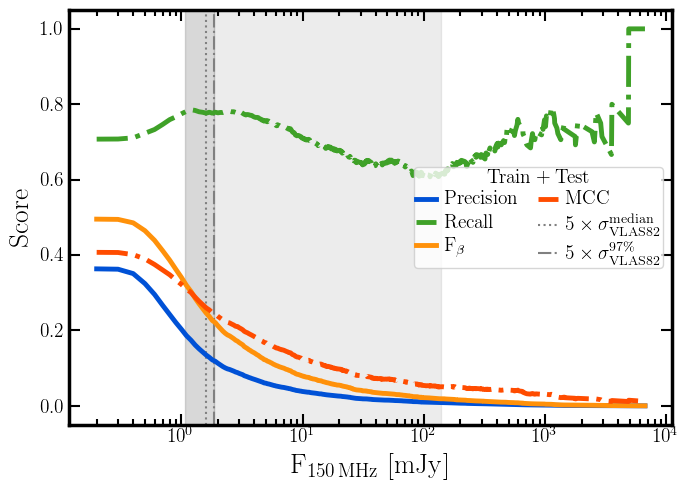

In [36]:
fig             = plt.figure(figsize=(7,5))
ax1             = fig.add_subplot(111, xscale='log')

ax1.plot(LOFAR_flx_range, radio_precs_flx, ls='-', marker='None', label=r'$\mathrm{Precision}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.05))
ax1.plot(LOFAR_flx_range, radio_recalls_flx, ls='-.', marker='None', label=r'$\mathrm{Recall}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.30))
# ax1.plot(LOFAR_flx_range, radio_accs_flx, ls='-', marker='None', label=r'$\mathrm{Accuracy}$', 
#          lw=3.5, color=plt.get_cmap('cet_rainbow')(0.50))
ax1.plot(LOFAR_flx_range, radio_f_scores_flx, ls='-', marker='None', label=r'$\mathrm{F}_{\beta}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.80))
ax1.plot(LOFAR_flx_range, radio_mccs_flx, ls='-.', marker='None', label=r'$\mathrm{MCC}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.95))

# ax1.axvline(x=5 * 25e-3, ls=':', lw=3.0, color='gray', zorder=1, label=r'$\mathrm{rms}_{\mathrm{LOFAR}}$')
# ax1.axvline(x=5 * 320e-3, ls=':', lw=3.0, color='gray', zorder=1, label=r'$\mathrm{rms}_{\mathrm{EMU}}$')
ax1.axvline(x=5 * 321e-3, ls=':', lw=1.5, color='gray', zorder=1, label=r'$5 \times \sigma_{\mathrm{VLAS82}}^{\mathrm{median}}$')
ax1.axvline(x=5 * 370e-3, ls='-.', lw=1.5, color='gray', zorder=1, label=r'$5 \times \sigma_{\mathrm{VLAS82}}^{97\%}$')
ax1.fill_betweenx(np.linspace(-1, 1.2), 5 * 216e-3, 5 * 370e-3, color='gray', zorder=0, alpha=0.30)  # 35 uJy -> 60 uJy
ax1.fill_betweenx(np.linspace(-1, 1.2), 5 * 370e-3, 5 * 277e-1, color='gray', zorder=0, alpha=0.15)  # 60 uJy -> 4.4 mJy

ax1.set_ylim(bottom=-0.05, top=1.05)
ax1.set_xlabel(r'$\mathrm{F}_{150 \, \mathrm{MHz}} ~ [\mathrm{mJy}]$', fontsize=20)
ax1.set_ylabel(r'$\mathrm{Score}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.legend(loc='center right', fontsize=14, title=r'$\mathrm{Train+Test}$', 
           title_fontsize=14, ncol=2, borderpad=0.1, labelspacing=0.3, 
           handlelength=1.0, handletextpad=0.4, columnspacing=1.0)
fig.tight_layout()
plt.show()

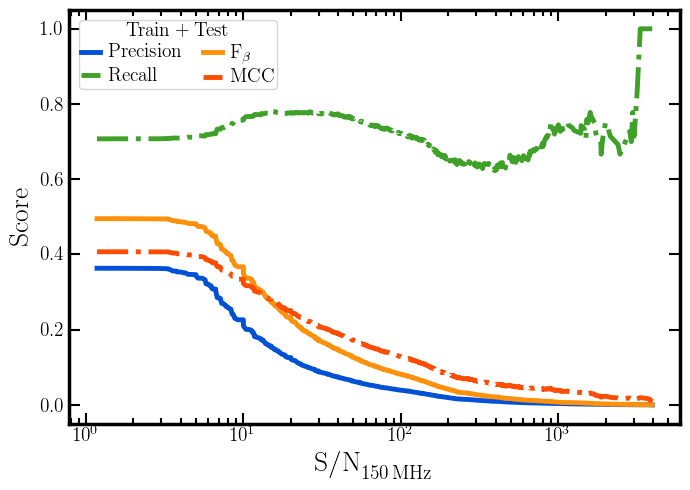

In [37]:
fig             = plt.figure(figsize=(7,5))
ax1             = fig.add_subplot(111, xscale='log')

ax1.plot(LOFAR_SNR_range, radio_precs_SNR, ls='-', marker='None', label=r'$\mathrm{Precision}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.05))
ax1.plot(LOFAR_SNR_range, radio_recalls_SNR, ls='-.', marker='None', label=r'$\mathrm{Recall}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.30))
# ax1.plot(LOFAR_SNR_range, radio_accs_SNR, ls='-', marker='None', label=r'$\mathrm{Accuracy}$', 
#          lw=3.5, color=plt.get_cmap('cet_rainbow')(0.50))
ax1.plot(LOFAR_SNR_range, radio_f_scores_SNR, ls='-', marker='None', label=r'$\mathrm{F}_{\beta}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.80))
ax1.plot(LOFAR_SNR_range, radio_mccs_SNR, ls='-.', marker='None', label=r'$\mathrm{MCC}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.95))

ax1.set_xlabel(r'$\mathrm{S/N}_{150 \, \mathrm{MHz}}$', fontsize=20)
ax1.set_ylabel(r'$\mathrm{Score}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.legend(loc='best', fontsize=14, title=r'$\mathrm{Train+Test}$', 
           title_fontsize=14, ncol=2, borderpad=0.1, labelspacing=0.3, 
           handlelength=1.0, handletextpad=0.4, columnspacing=1.0)
fig.tight_layout()
plt.show()

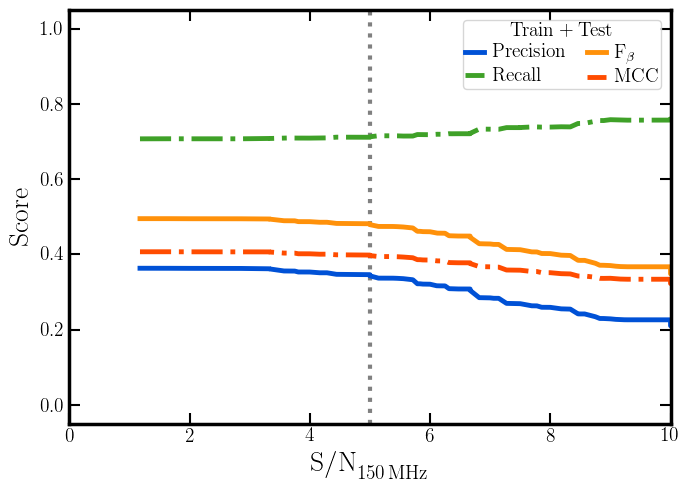

In [38]:
fig             = plt.figure(figsize=(7,5))
ax1             = fig.add_subplot(111, xscale='linear')

ax1.plot(LOFAR_SNR_range, radio_precs_SNR, ls='-', marker='None', label=r'$\mathrm{Precision}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.05))
ax1.plot(LOFAR_SNR_range, radio_recalls_SNR, ls='-.', marker='None', label=r'$\mathrm{Recall}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.30))
# ax1.plot(LOFAR_SNR_range, radio_accs_SNR, ls='-', marker='None', label=r'$\mathrm{Accuracy}$', 
#          lw=3.5, color=plt.get_cmap('cet_rainbow')(0.50))
ax1.plot(LOFAR_SNR_range, radio_f_scores_SNR, ls='-', marker='None', label=r'$\mathrm{F}_{\beta}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.80))
ax1.plot(LOFAR_SNR_range, radio_mccs_SNR, ls='-.', marker='None', label=r'$\mathrm{MCC}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.95))
ax1.axvline(x=5.0, ls=':', lw=3.0, color='gray', zorder=1)

ax1.set_xlim(left=0.0, right=10.0)
ax1.set_xlabel(r'$\mathrm{S/N}_{150 \, \mathrm{MHz}}$', fontsize=20)
ax1.set_ylabel(r'$\mathrm{Score}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.legend(loc='best', fontsize=14, title=r'$\mathrm{Train+Test}$', 
           title_fontsize=14, ncol=2, borderpad=0.1, labelspacing=0.3, 
           handlelength=1.0, handletextpad=0.4, columnspacing=1.0)
fig.tight_layout()
plt.show()

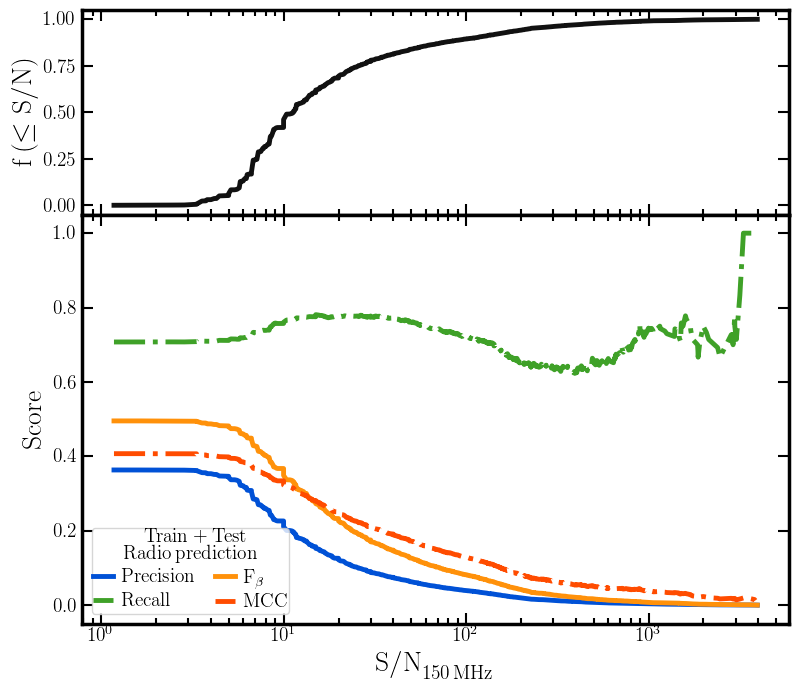

In [81]:
fig             = plt.figure(figsize=(8,7))

grid   = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[1, 2], hspace=0.0)
axs    = {}
axs[0] = fig.add_subplot(grid[0, 0], xscale='log', yscale='linear')
axs[1] = fig.add_subplot(grid[1, 0], xscale='log', sharex=axs[0])

# axs[0].plot(LOFAR_SNR_range, num_high_SNR / np.sum(filter_pred_AGN_train_test), ls='-', 
#             marker='None', lw=3.5, color='k')
axs[0].plot(LOFAR_SNR_range, num_low_SNR / num_low_SNR[-1], ls='-', marker='None', lw=3.5, color='k')

axs[1].plot(LOFAR_SNR_range, radio_precs_SNR, ls='-', marker='None', label=r'$\mathrm{Precision}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.05))
axs[1].plot(LOFAR_SNR_range, radio_recalls_SNR, ls='-.', marker='None', label=r'$\mathrm{Recall}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.30))
axs[1].plot(LOFAR_SNR_range, radio_f_scores_SNR, ls='-', marker='None', label=r'$\mathrm{F}_{\beta}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.80))
axs[1].plot(LOFAR_SNR_range, radio_mccs_SNR, ls='-.', marker='None', label=r'$\mathrm{MCC}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.95))

axs[1].set_xlabel(r'$\mathrm{S/N}_{150 \, \mathrm{MHz}}$', fontsize=20)
axs[1].set_ylabel(r'$\mathrm{Score}$', fontsize=20)
axs[0].set_ylabel(r'$\mathrm{f} \left( \leq \mathrm{S/N} \right)$', fontsize=20)

for count in [0, 1]:
    axs[count].tick_params(which='both', top=True, right=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
axs[1].legend(loc='lower left', fontsize=14, title=r'$\mathrm{Train+Test}\\\mathrm{Radio\, prediction}$', 
           title_fontsize=14, ncol=2, borderpad=0.1, labelspacing=0.3, 
           handlelength=1.0, handletextpad=0.4, columnspacing=1.0)
fig.tight_layout()
plt.show()

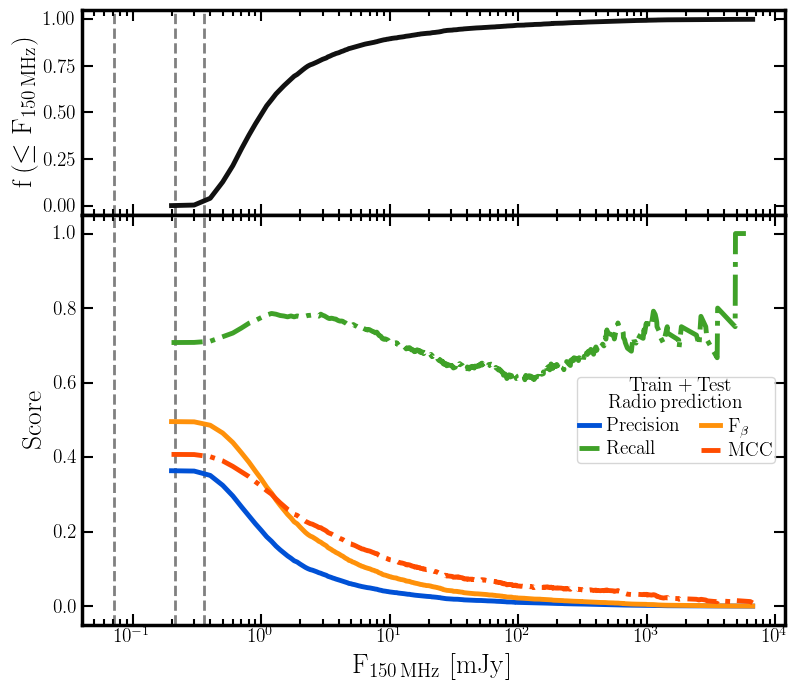

In [79]:
fig             = plt.figure(figsize=(8,7))

grid   = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[1, 2], hspace=0.0)
axs    = {}
axs[0] = fig.add_subplot(grid[0, 0], xscale='log', yscale='linear')
axs[1] = fig.add_subplot(grid[1, 0], xscale='log', sharex=axs[0])

axs[0].plot(LOFAR_flx_range, num_low_flx / num_low_flx[-1], ls='-', marker='None', lw=3.5, color='k')

axs[1].plot(LOFAR_flx_range, radio_precs_flx, ls='-', marker='None', label=r'$\mathrm{Precision}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.05))
axs[1].plot(LOFAR_flx_range, radio_recalls_flx, ls='-.', marker='None', label=r'$\mathrm{Recall}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.30))
axs[1].plot(LOFAR_flx_range, radio_f_scores_flx, ls='-', marker='None', label=r'$\mathrm{F}_{\beta}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.80))
axs[1].plot(LOFAR_flx_range, radio_mccs_flx, ls='-.', marker='None', label=r'$\mathrm{MCC}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.95))

for count in [0, 1]:
    axs[count].axvline(x=1 * 71e-3, ls='--', lw=2.0, c='gray', zorder=1)
    axs[count].axvline(x=3 * 71e-3, ls='--', lw=2.0, c='gray', zorder=1)
    axs[count].axvline(x=5 * 71e-3, ls='--', lw=2.0, c='gray', zorder=1)

axs[1].set_xlabel(r'$\mathrm{F}_{150 \, \mathrm{MHz}} ~ [\mathrm{mJy}]$', fontsize=20)
axs[1].set_ylabel(r'$\mathrm{Score}$', fontsize=20)
axs[0].set_ylabel(r'$\mathrm{f} \left( \leq \mathrm{F}_{150 \, \mathrm{MHz}} \right)$', fontsize=20)

for count in [0, 1]:
    axs[count].tick_params(which='both', top=True, right=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
axs[1].legend(loc='center right', fontsize=14, title=r'$\mathrm{Train+Test}\\\mathrm{Radio\, prediction}$', 
           title_fontsize=14, ncol=2, borderpad=0.1, labelspacing=0.3, 
           handlelength=1.0, handletextpad=0.4, columnspacing=1.0)
fig.tight_layout()
plt.show()

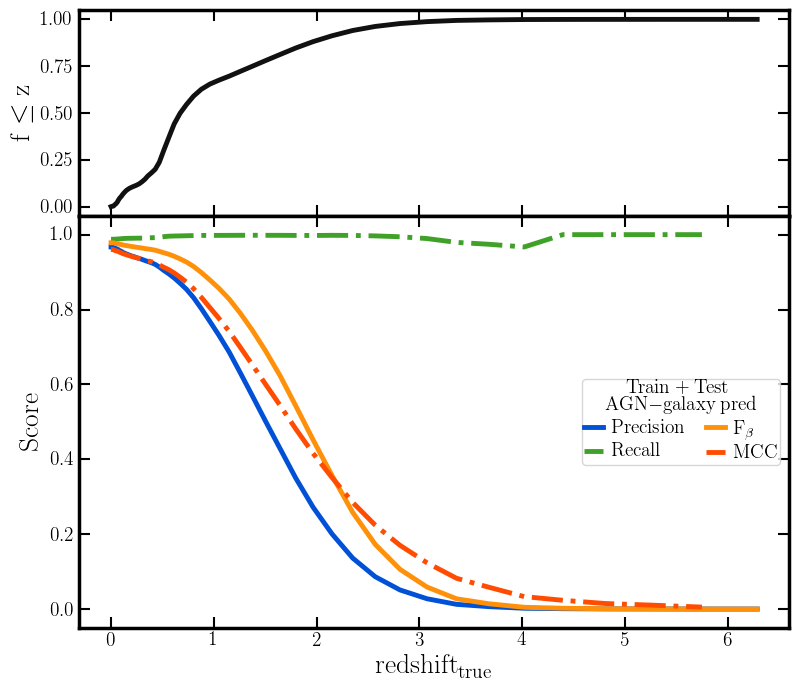

In [70]:
fig             = plt.figure(figsize=(8,7))

grid   = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[1, 2], hspace=0.0)
axs    = {}
axs[0] = fig.add_subplot(grid[0, 0], xscale='linear', yscale='linear')
axs[1] = fig.add_subplot(grid[1, 0], xscale='linear', sharex=axs[0])

axs[0].plot(LOFAR_z_range, num_low_z / num_low_z[-1], ls='-', marker='None', lw=3.5, color='k')

axs[1].plot(LOFAR_z_range, radio_precs_z, ls='-', marker='None', label=r'$\mathrm{Precision}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.05))
axs[1].plot(LOFAR_z_range, radio_recalls_z, ls='-.', marker='None', label=r'$\mathrm{Recall}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.30))
axs[1].plot(LOFAR_z_range, radio_f_scores_z, ls='-', marker='None', label=r'$\mathrm{F}_{\beta}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.80))
axs[1].plot(LOFAR_z_range, radio_mccs_z, ls='-.', marker='None', label=r'$\mathrm{MCC}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.95))

axs[1].set_xlabel(r'$\mathrm{redshift}_{\mathrm{true}}$', fontsize=20)
axs[1].set_ylabel(r'$\mathrm{Score}$', fontsize=20)
axs[0].set_ylabel(r'$\mathrm{f} \leq \mathrm{z}$', fontsize=20)

for count in [0, 1]:
    axs[count].tick_params(which='both', top=True, right=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
axs[1].legend(loc='center right', fontsize=14, title=r'$\mathrm{Train+Test}\\\mathrm{AGN{-}galaxy\, pred}$', 
           title_fontsize=14, ncol=2, borderpad=0.1, labelspacing=0.3,
           handlelength=1.0, handletextpad=0.4, columnspacing=1.0)
fig.tight_layout()
plt.show()

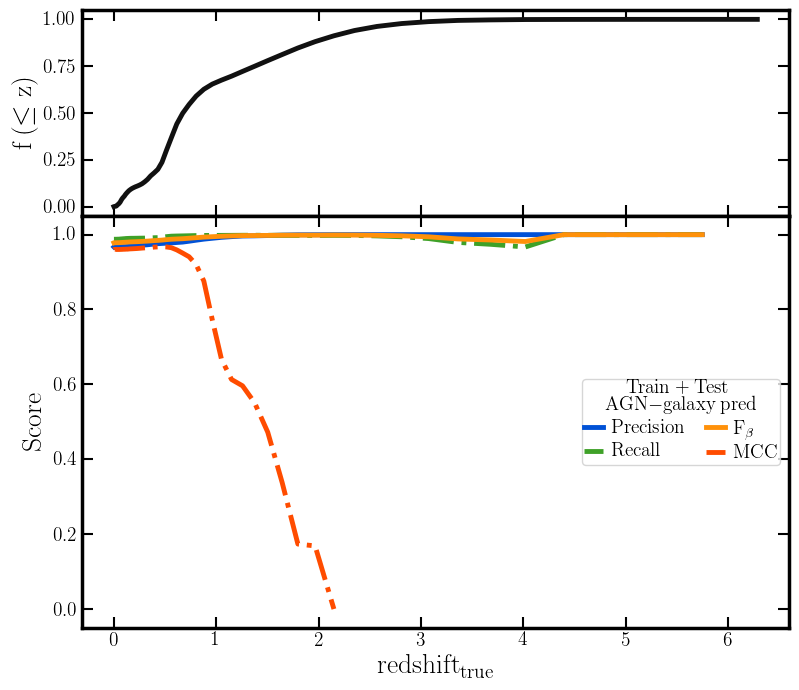

In [71]:
fig             = plt.figure(figsize=(8,7))

grid   = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[1, 2], hspace=0.0)
axs    = {}
axs[0] = fig.add_subplot(grid[0, 0], xscale='linear', yscale='linear')
axs[1] = fig.add_subplot(grid[1, 0], xscale='linear', sharex=axs[0])

axs[0].plot(LOFAR_z_range, num_low_z / num_low_z[-1], ls='-', marker='None', lw=3.5, color='k')

axs[1].plot(LOFAR_z_range, radio_precs_high_z, ls='-', marker='None', label=r'$\mathrm{Precision}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.05))
axs[1].plot(LOFAR_z_range, radio_recalls_high_z, ls='-.', marker='None', label=r'$\mathrm{Recall}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.30))
axs[1].plot(LOFAR_z_range, radio_f_scores_high_z, ls='-', marker='None', label=r'$\mathrm{F}_{\beta}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.80))
axs[1].plot(LOFAR_z_range, radio_mccs_high_z, ls='-.', marker='None', label=r'$\mathrm{MCC}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.95))

axs[1].set_xlabel(r'$\mathrm{redshift}_{\mathrm{true}}$', fontsize=20)
axs[1].set_ylabel(r'$\mathrm{Score}$', fontsize=20)
axs[0].set_ylabel(r'$\mathrm{f} \left( \leq \mathrm{z} \right)$', fontsize=20)

for count in [0, 1]:
    axs[count].tick_params(which='both', top=True, right=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
axs[1].legend(loc='center right', fontsize=14, title=r'$\mathrm{Train+Test}\\\mathrm{AGN{-}galaxy\, pred}$', 
           title_fontsize=14, ncol=2, borderpad=0.1, labelspacing=0.3,
           handlelength=1.0, handletextpad=0.4, columnspacing=1.0)
fig.tight_layout()
plt.show()

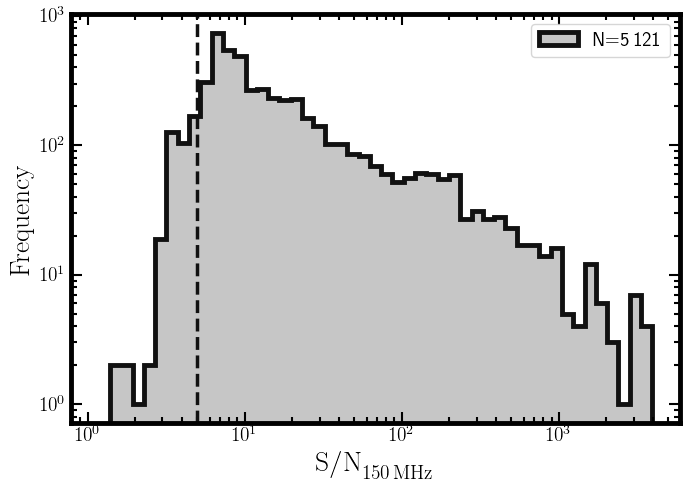

In [43]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='log', yscale='log')

set_to_plot     = train_test_df

min_SNR  = np.nanmin(selected_df.loc[filter_AGN_train_test, 'SNR_LOFAR'])
max_SNR  = np.nanmax(selected_df.loc[filter_AGN_train_test, 'SNR_LOFAR'])
SNR_bins = np.logspace(np.log10(min_SNR), np.log10(max_SNR), 50)

sample_size = np.nansum(np.array(selected_df.loc[filter_AGN_train_test, 'SNR_LOFAR'] > 0))

ax1.hist(selected_df.loc[filter_AGN_train_test, 'SNR_LOFAR'], bins=SNR_bins, histtype='stepfilled', 
         ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, 
         label=f'N={sample_size:,}'.replace(',', '$\,$'))
ax1.axvline(x=5, ls='--', lw=2.5, c='k')
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel(r'$\mathrm{S/N}_{150 \, \mathrm{MHz}}$', size=20)
ax1.set_ylabel(r'$\mathrm{Frequency}$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
plt.show()

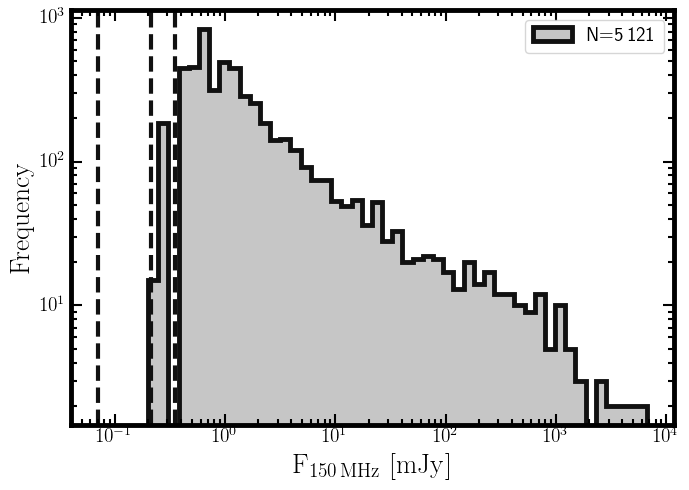

In [77]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='log', yscale='log')

set_to_plot     = train_test_df

min_Sint  = np.nanmin(selected_df.loc[filter_AGN_train_test, 'Sint_LOFAR_non_imp'])
max_Sint  = np.nanmax(selected_df.loc[filter_AGN_train_test, 'Sint_LOFAR_non_imp'])
Sint_bins = np.logspace(np.log10(min_Sint), np.log10(max_Sint), 50)

sample_size = np.nansum(np.array(selected_df.loc[filter_AGN_train_test, 'Sint_LOFAR_non_imp'] > 0))

ax1.hist(selected_df.loc[filter_AGN_train_test, 'Sint_LOFAR_non_imp'], bins=Sint_bins, histtype='stepfilled', 
         ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, 
         label=f'N={sample_size:,}'.replace(',', '$\,$'))
ax1.axvline(x=71e-3, ls='--', lw=3.0, c='k', zorder=1)
ax1.axvline(x=3 * 71e-3, ls='--', lw=3.0, c='k', zorder=1)
ax1.axvline(x=5 * 71e-3, ls='--', lw=3.0, c='k', zorder=1)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel(r'$\mathrm{F}_{150 \, \mathrm{MHz}} ~ [\mathrm{mJy}]$', size=20)
ax1.set_ylabel(r'$\mathrm{Frequency}$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
plt.show()

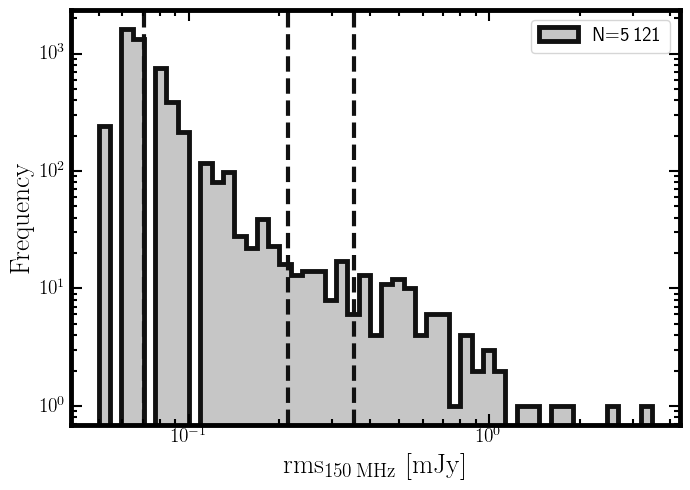

In [76]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='log', yscale='log')

set_to_plot     = train_test_df

min_rms  = np.nanmin(selected_df.loc[filter_AGN_train_test, 'rms_LOFAR'])
max_rms  = np.nanmax(selected_df.loc[filter_AGN_train_test, 'rms_LOFAR'])
rms_bins = np.logspace(np.log10(min_rms), np.log10(max_rms), 50)

sample_size = np.nansum(np.array(selected_df.loc[filter_AGN_train_test, 'rms_LOFAR'] > 0))

ax1.hist(selected_df.loc[filter_AGN_train_test, 'rms_LOFAR'], bins=rms_bins, histtype='stepfilled', 
         ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, 
         label=f'N={sample_size:,}'.replace(',', '$\,$'))
ax1.axvline(x=71e-3, ls='--', lw=3.0, c='k', zorder=1)
ax1.axvline(x=3 * 71e-3, ls='--', lw=3.0, c='k', zorder=1)
ax1.axvline(x=5 * 71e-3, ls='--', lw=3.0, c='k', zorder=1)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel(r'$\mathrm{rms}_{150 \, \mathrm{MHz}} ~ [\mathrm{mJy}]$', size=20)
ax1.set_ylabel(r'$\mathrm{Frequency}$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
plt.show()

In [46]:
nstep = 4
seq_cont   = np.logspace(-1.5, 0.0, nstep)
seq_cont   = np.insert(seq_cont, 0, 0.0)
seq_fill   = np.logspace(-1.5, 0.0, nstep+2)
seq_fill   = np.insert(seq_fill, 0, 0.0)

In [67]:
selected_df.loc[filter_AGN_train_test, 
                ['log_Sint_LOFAR_non_imp', 'Sint_LOFAR_non_imp', 
                 'log_SNR_LOFAR', 'SNR_LOFAR', 'SNR_LOFAR_int']].describe(percentiles=[0.01, .25, .5, .75, .99])

,log_Sint_LOFAR_non_imp,Sint_LOFAR_non_imp,log_SNR_LOFAR,SNR_LOFAR,SNR_LOFAR_int
count,5121.000000,5121.000000,5121.000000,5121.000000,5121.000000
mean,0.190233,25.233528,1.215397,59.916409,87.713737
std,0.664360,217.681198,0.536553,223.884766,370.664368
min,-0.698970,0.200000,0.070581,1.176471,3.333333
1%,-0.522879,0.300000,0.522879,3.333333,4.285715
25%,-0.221849,0.600000,0.853872,7.142857,8.333334
50%,0.000000,1.000000,1.051152,11.250000,13.333334
75%,0.361728,2.300000,1.410174,25.714285,30.000000
99%,2.752973,566.219971,2.967661,928.274292,1599.400146
max,3.822913,6651.399902,3.596029,3944.838867,9502.000000


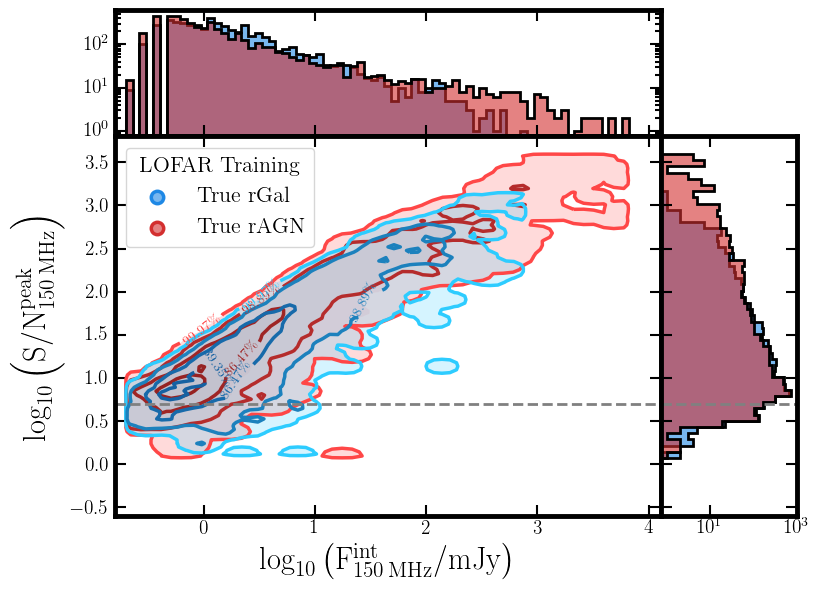

In [48]:
sigma_limit_LOFAR = 1
fig    = plt.figure(figsize=(8, 6))
# ax1    = fig.add_subplot(111, yscale='log')


grid   = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[4, 1],
                          height_ratios=[1, 3], hspace=0.0, wspace=0.0)
axs    = {}
axs[0] = fig.add_subplot(grid[0, 0], yscale='log')
axs[1] = fig.add_subplot(grid[1, 0], yscale='linear', xscale='linear', sharex=axs[0])
axs[2] = fig.add_subplot(grid[1, 1], xscale='log', yscale='linear', sharey=axs[1])

filt_posit = np.isfinite(selected_df.loc[:, 'log_Sint_LOFAR_non_imp']) & np.isfinite(selected_df.loc[:, 'log_SNR_LOFAR'])

min_Sint = np.nanmin(selected_df.loc[filt_radio_det & filt_confirmed & filt_posit, 'log_Sint_LOFAR_non_imp'].values)
max_Sint = np.nanmax(selected_df.loc[filt_radio_det & filt_confirmed & filt_posit, 'log_Sint_LOFAR_non_imp'].values)

min_SNR  = np.nanmin(selected_df.loc[filt_radio_det & filt_confirmed & filt_posit, 'log_SNR_LOFAR'].values)
max_SNR  = np.nanmax(selected_df.loc[filt_radio_det & filt_confirmed & filt_posit, 'log_SNR_LOFAR'].values)

n_bins   = [50, 75]

bins_Sint = np.linspace(min_Sint, max_Sint, n_bins[1])
bins_SNR  = np.linspace(min_SNR, max_SNR, n_bins[0])

sigmas_perc     = [0.39346934, 0.86466472, 0.988891, 0.99966454]  # [0.39346934, 0.86466472, 0.988891, 0.99966454, 0.99999627]
sigmas_perc_inv = [1. - sigma for sigma in sigmas_perc][::-1]  # 1, 2, 3, 4 sigma (2-dimensional)

H_rGal, xedges_rGal, yedges_rGal = np.histogram2d(selected_df.loc[filt_real_rGal & filt_posit, 'log_Sint_LOFAR_non_imp'], 
                                   selected_df.loc[filt_real_rGal & filt_posit, 'log_SNR_LOFAR'], bins=n_bins)
H_rAGN, xedges_rAGN, yedges_rAGN = np.histogram2d(selected_df.loc[filt_real_rAGN & filt_posit, 'log_Sint_LOFAR_non_imp'], 
                                   selected_df.loc[filt_real_rAGN & filt_posit, 'log_SNR_LOFAR'], bins=n_bins)

H_rAGN_smooth = clean_and_smooth_matrix(H_rAGN, sigma=0.9)
H_rGal_smooth = clean_and_smooth_matrix(H_rGal, sigma=0.9)

Z_rAGN = (H_rAGN_smooth.T - H_rAGN_smooth.T.min())/(H_rAGN_smooth.T.max() - H_rAGN_smooth.T.min())
Z_rGal = (H_rGal_smooth.T - H_rGal_smooth.T.min())/(H_rGal_smooth.T.max() - H_rGal_smooth.T.min())

# fix probable lines not closing
# Z_rAGN = make_borders_zero(Z_rAGN)
# Z_rGal = make_borders_zero(Z_rGal)
Z_rAGN, x_centers_rAGN, y_centers_rAGN = pad_matrix_zeros(Z_rAGN, xedges_rAGN, yedges_rAGN)
Z_rGal, x_centers_rGal, y_centers_rGal = pad_matrix_zeros(Z_rGal, xedges_rGal, yedges_rGal)

CS_rAGN_f = axs[1].contourf(x_centers_rAGN, y_centers_rAGN, Z_rAGN, levels=sigmas_perc_inv, 
                            colors=cm_gradient_rAGN(seq_fill[::-1]), extend='max', 
                            alpha=0.2, antialiased=True)
CS_rAGN = axs[1].contour(x_centers_rAGN, y_centers_rAGN, Z_rAGN, levels=sigmas_perc_inv, 
                         colors=cm_gradient_rAGN(seq_cont[::-1]), linewidths=2.5)
for count in np.arange(1):  # times to run nex command, more labels
    axs[1].clabel(CS_rAGN, CS_rAGN.levels, inline=True, fmt=fmt, fontsize=10)

CS_rGal_f = axs[1].contourf(x_centers_rGal, y_centers_rGal, Z_rGal, levels=sigmas_perc_inv, 
                            colors=cm_gradient_rGal(seq_fill[::-1]), extend='max', 
                            alpha=0.2, antialiased=True)
CS_rGal = axs[1].contour(x_centers_rGal, y_centers_rGal, Z_rGal, levels=sigmas_perc_inv, 
                         colors=cm_gradient_rGal(seq_cont[::-1]), linewidths=2.5)
for count in np.arange(1):  # times to run nex command, more labels
    axs[1].clabel(CS_rGal, CS_rGal.levels, inline=True, fmt=fmt, fontsize=10)

axs[1].scatter([-10], [-10], marker='o', edgecolor=colour_rGal, color=colour_rGal_shade, s=80, label='$\mathrm{True ~ rGal}$', linewidths=2.5)
axs[1].scatter([-10], [-10], marker='o', edgecolor=colour_rAGN, color=colour_rAGN_shade, s=80, label='$\mathrm{True ~ rAGN}$', linewidths=2.5)

axs[1].axhline(y=np.log10(5), ls='--', lw=2.0, c='gray')


axs[0].hist(selected_df.loc[filt_real_rGal & filt_posit, 'log_Sint_LOFAR_non_imp'], bins=bins_Sint, 
            histtype='stepfilled', fc=colour_rGal_shade, ec=(0, 0, 0, 1), lw=2)
axs[0].hist(selected_df.loc[filt_real_rAGN & filt_posit, 'log_Sint_LOFAR_non_imp'], bins=bins_Sint, 
            histtype='stepfilled', fc=colour_rAGN_shade, ec=(0, 0, 0, 1), lw=2)

axs[2].hist(selected_df.loc[filt_real_rGal & filt_posit, 'log_SNR_LOFAR'], 
            bins=bins_SNR, orientation='horizontal', histtype='stepfilled', 
            fc=colour_rGal_shade, ec=(0, 0, 0, 1), lw=2)
axs[2].hist(selected_df.loc[filt_real_rAGN & filt_posit, 'log_SNR_LOFAR'], 
            bins=bins_SNR, orientation='horizontal', histtype='stepfilled', 
            fc=colour_rAGN_shade, ec=(0, 0, 0, 1), lw=2)
axs[2].axhline(y=np.log10(5), ls='--', lw=2.0, c='gray')

axs[1].legend(loc='upper left', fontsize=16, title=r'$\mathrm{LOFAR ~ Training}$', title_fontsize=16)
axs[1].set_xlabel(r'$\log_{10}\left( \mathrm{F}_{150 \, \mathrm{MHz}}^{\mathrm{int}} / \mathrm{mJy} \right)$', fontsize=22)
axs[1].set_ylabel(r'$\log_{10}\left( \mathrm{S/N}_{150 \, \mathrm{MHz}}^{\mathrm{peak}} \right)$', fontsize=22)
for ax_count in [0, 1, 2]:
    axs[ax_count].tick_params(which='both', top=True, right=True, direction='in')
    axs[ax_count].tick_params(axis='both', which='major', labelsize=14)
    axs[ax_count].tick_params(which='major', length=8, width=1.5)
    axs[ax_count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[ax_count].spines.values(), linewidth=3.5)
    plt.setp(axs[ax_count].spines.values(), linewidth=3.5)
plt.setp(axs[2].get_yticklabels(), visible=False)
axs[1].set_ylim(bottom=-0.6, top=3.8)
axs[1].set_xlim(left=-0.8, right=4.11)
plt.tight_layout()
plt.show()

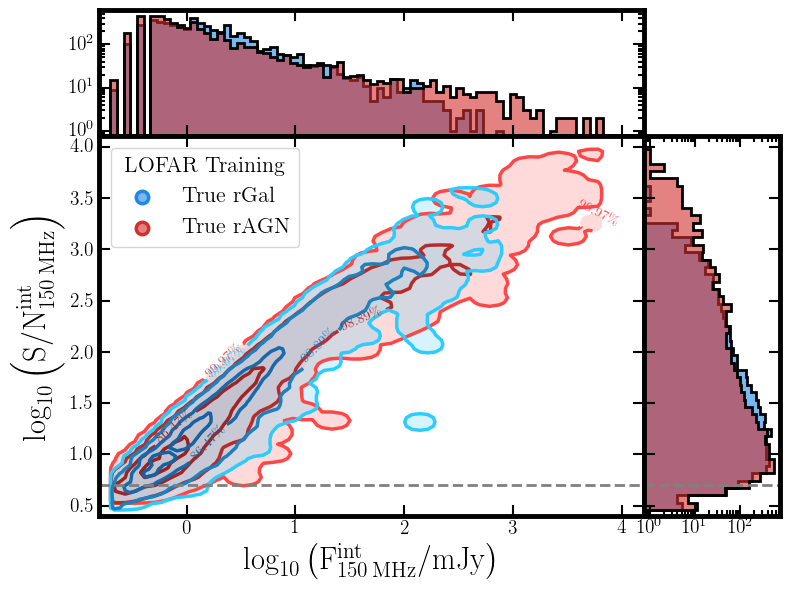

In [49]:
sigma_limit_LOFAR = 1
fig    = plt.figure(figsize=(8, 6))
# ax1    = fig.add_subplot(111, yscale='log')


grid   = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[4, 1],
                          height_ratios=[1, 3], hspace=0.0, wspace=0.0)
axs    = {}
axs[0] = fig.add_subplot(grid[0, 0], yscale='log')
axs[1] = fig.add_subplot(grid[1, 0], yscale='linear', xscale='linear', sharex=axs[0])
axs[2] = fig.add_subplot(grid[1, 1], xscale='log', yscale='linear', sharey=axs[1])

filt_posit = np.isfinite(selected_df.loc[:, 'log_Sint_LOFAR_non_imp']) & np.isfinite(selected_df.loc[:, 'log_SNR_LOFAR_int'])

min_Sint = np.nanmin(selected_df.loc[filt_radio_det & filt_confirmed & filt_posit, 'log_Sint_LOFAR_non_imp'].values)
max_Sint = np.nanmax(selected_df.loc[filt_radio_det & filt_confirmed & filt_posit, 'log_Sint_LOFAR_non_imp'].values)

min_SNR  = np.nanmin(selected_df.loc[filt_radio_det & filt_confirmed & filt_posit, 'log_SNR_LOFAR_int'].values)
max_SNR  = np.nanmax(selected_df.loc[filt_radio_det & filt_confirmed & filt_posit, 'log_SNR_LOFAR_int'].values)

n_bins   = [50, 75]

bins_Sint = np.linspace(min_Sint, max_Sint, n_bins[1])
bins_SNR  = np.linspace(min_SNR, max_SNR, n_bins[0])

sigmas_perc     = [0.39346934, 0.86466472, 0.988891, 0.99966454]  # [0.39346934, 0.86466472, 0.988891, 0.99966454, 0.99999627]
sigmas_perc_inv = [1. - sigma for sigma in sigmas_perc][::-1]  # 1, 2, 3, 4 sigma (2-dimensional)

H_rGal, xedges_rGal, yedges_rGal = np.histogram2d(selected_df.loc[filt_real_rGal & filt_posit, 'log_Sint_LOFAR_non_imp'], 
                                   selected_df.loc[filt_real_rGal & filt_posit, 'log_SNR_LOFAR_int'], bins=n_bins)
H_rAGN, xedges_rAGN, yedges_rAGN = np.histogram2d(selected_df.loc[filt_real_rAGN & filt_posit, 'log_Sint_LOFAR_non_imp'], 
                                   selected_df.loc[filt_real_rAGN & filt_posit, 'log_SNR_LOFAR_int'], bins=n_bins)

H_rAGN_smooth = clean_and_smooth_matrix(H_rAGN, sigma=0.9)
H_rGal_smooth = clean_and_smooth_matrix(H_rGal, sigma=0.9)

Z_rAGN = (H_rAGN_smooth.T - H_rAGN_smooth.T.min())/(H_rAGN_smooth.T.max() - H_rAGN_smooth.T.min())
Z_rGal = (H_rGal_smooth.T - H_rGal_smooth.T.min())/(H_rGal_smooth.T.max() - H_rGal_smooth.T.min())

# fix probable lines not closing
# Z_rAGN = make_borders_zero(Z_rAGN)
# Z_rGal = make_borders_zero(Z_rGal)
Z_rAGN, x_centers_rAGN, y_centers_rAGN = pad_matrix_zeros(Z_rAGN, xedges_rAGN, yedges_rAGN)
Z_rGal, x_centers_rGal, y_centers_rGal = pad_matrix_zeros(Z_rGal, xedges_rGal, yedges_rGal)

CS_rAGN_f = axs[1].contourf(x_centers_rAGN, y_centers_rAGN, Z_rAGN, levels=sigmas_perc_inv, 
                            colors=cm_gradient_rAGN(seq_fill[::-1]), extend='max', 
                            alpha=0.2, antialiased=True)
CS_rAGN = axs[1].contour(x_centers_rAGN, y_centers_rAGN, Z_rAGN, levels=sigmas_perc_inv, 
                         colors=cm_gradient_rAGN(seq_cont[::-1]), linewidths=2.5)
for count in np.arange(1):  # times to run nex command, more labels
    axs[1].clabel(CS_rAGN, CS_rAGN.levels, inline=True, fmt=fmt, fontsize=10)

CS_rGal_f = axs[1].contourf(x_centers_rGal, y_centers_rGal, Z_rGal, levels=sigmas_perc_inv, 
                            colors=cm_gradient_rGal(seq_fill[::-1]), extend='max', 
                            alpha=0.2, antialiased=True)
CS_rGal = axs[1].contour(x_centers_rGal, y_centers_rGal, Z_rGal, levels=sigmas_perc_inv, 
                         colors=cm_gradient_rGal(seq_cont[::-1]), linewidths=2.5)
for count in np.arange(1):  # times to run nex command, more labels
    axs[1].clabel(CS_rGal, CS_rGal.levels, inline=True, fmt=fmt, fontsize=10)

axs[1].scatter([-10], [-10], marker='o', edgecolor=colour_rGal, color=colour_rGal_shade, s=80, label='$\mathrm{True ~ rGal}$', linewidths=2.5)
axs[1].scatter([-10], [-10], marker='o', edgecolor=colour_rAGN, color=colour_rAGN_shade, s=80, label='$\mathrm{True ~ rAGN}$', linewidths=2.5)

axs[1].axhline(y=np.log10(5), ls='--', lw=2.0, c='gray')


axs[0].hist(selected_df.loc[filt_real_rGal & filt_posit, 'log_Sint_LOFAR_non_imp'], bins=bins_Sint, 
            histtype='stepfilled', fc=colour_rGal_shade, ec=(0, 0, 0, 1), lw=2)
axs[0].hist(selected_df.loc[filt_real_rAGN & filt_posit, 'log_Sint_LOFAR_non_imp'], bins=bins_Sint, 
            histtype='stepfilled', fc=colour_rAGN_shade, ec=(0, 0, 0, 1), lw=2)

axs[2].hist(selected_df.loc[filt_real_rGal & filt_posit, 'log_SNR_LOFAR_int'], 
            bins=bins_SNR, orientation='horizontal', histtype='stepfilled', 
            fc=colour_rGal_shade, ec=(0, 0, 0, 1), lw=2)
axs[2].hist(selected_df.loc[filt_real_rAGN & filt_posit, 'log_SNR_LOFAR_int'], 
            bins=bins_SNR, orientation='horizontal', histtype='stepfilled', 
            fc=colour_rAGN_shade, ec=(0, 0, 0, 1), lw=2)
axs[2].axhline(y=np.log10(5), ls='--', lw=2.0, c='gray')

axs[1].legend(loc='upper left', fontsize=16, title=r'$\mathrm{LOFAR ~ Training}$', title_fontsize=16)
axs[1].set_xlabel(r'$\log_{10}\left( \mathrm{F}_{150 \, \mathrm{MHz}}^{\mathrm{int}} / \mathrm{mJy} \right)$', fontsize=22)
axs[1].set_ylabel(r'$\log_{10}\left( \mathrm{S/N}_{150 \, \mathrm{MHz}}^{\mathrm{int}} \right)$', fontsize=22)
for ax_count in [0, 1, 2]:
    axs[ax_count].tick_params(which='both', top=True, right=True, direction='in')
    axs[ax_count].tick_params(axis='both', which='major', labelsize=14)
    axs[ax_count].tick_params(which='major', length=8, width=1.5)
    axs[ax_count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[ax_count].spines.values(), linewidth=3.5)
    plt.setp(axs[ax_count].spines.values(), linewidth=3.5)
plt.setp(axs[2].get_yticklabels(), visible=False)
axs[1].set_ylim(bottom=0.4, top=4.1)
axs[1].set_xlim(left=-0.8, right=4.2)
plt.tight_layout()
plt.show()

In [50]:
np.sum(np.array(selected_df.loc[:, 'class'] == 1))

40430

In [51]:
np.sum(np.array(selected_df.loc[:, 'class'] == 0))

54557

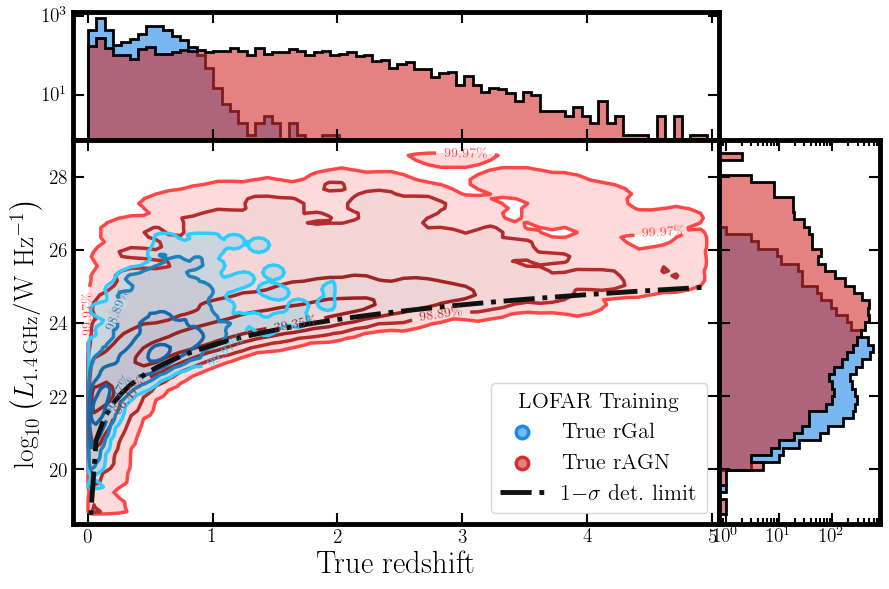

In [52]:
sigma_limit_LOFAR = 1
fig    = plt.figure(figsize=(9, 6))
# ax1    = fig.add_subplot(111, yscale='log')


grid   = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[4, 1],
                          height_ratios=[1, 3], hspace=0.0, wspace=0.0)
axs    = {}
axs[0] = fig.add_subplot(grid[0, 0], yscale='log')
axs[1] = fig.add_subplot(grid[1, 0], yscale='linear', sharex=axs[0])
axs[2] = fig.add_subplot(grid[1, 1], xscale='log', yscale='linear', sharey=axs[1])

filt_posit = np.array(selected_df.loc[:, 'Z'] > 0) & np.array(selected_df.loc[:, 'log_lum_14_GHz'] > 0)

min_z = np.nanmin(selected_df.loc[filt_radio_det & filt_confirmed & filt_posit, 'Z'].values)
max_z = np.nanmax(selected_df.loc[filt_radio_det & filt_confirmed & filt_posit, 'Z'].values)

min_lum  = np.nanmin(selected_df.loc[filt_radio_det & filt_confirmed & filt_posit, 'log_lum_14_GHz'].values)
max_lum  = np.nanmax(selected_df.loc[filt_radio_det & filt_confirmed & filt_posit, 'log_lum_14_GHz'].values)

n_bins   = [50, 75]

bins_z   = np.linspace(min_z, max_z, n_bins[1])
# bins_lum = np.logspace(np.log10(min_lum), np.log10(max_lum), n_bins[0])
bins_lum = np.linspace(min_lum, max_lum, n_bins[0])

sigmas_perc     = [0.39346934, 0.86466472, 0.988891, 0.99966454]  # [0.39346934, 0.86466472, 0.988891, 0.99966454, 0.99999627]
sigmas_perc_inv = [1. - sigma for sigma in sigmas_perc][::-1]  # 1, 2, 3, 4 sigma (2-dimensional)

H_rGal, xedges_rGal, yedges_rGal = np.histogram2d(selected_df.loc[filt_real_rGal & filt_posit, 'Z'], 
                                   selected_df.loc[filt_real_rGal & filt_posit, 'log_lum_14_GHz'], bins=n_bins)
H_rAGN, xedges_rAGN, yedges_rAGN = np.histogram2d(selected_df.loc[filt_real_rAGN & filt_posit, 'Z'], 
                                   selected_df.loc[filt_real_rAGN & filt_posit, 'log_lum_14_GHz'], bins=n_bins)

H_rAGN_smooth = clean_and_smooth_matrix(H_rAGN, sigma=0.9)
H_rGal_smooth = clean_and_smooth_matrix(H_rGal, sigma=0.9)

Z_rAGN = (H_rAGN_smooth.T - H_rAGN_smooth.T.min())/(H_rAGN_smooth.T.max() - H_rAGN_smooth.T.min())
Z_rGal = (H_rGal_smooth.T - H_rGal_smooth.T.min())/(H_rGal_smooth.T.max() - H_rGal_smooth.T.min())

# fix probable lines not closing
# Z_rAGN = make_borders_zero(Z_rAGN)
# Z_rGal = make_borders_zero(Z_rGal)
Z_rAGN, x_centers_rAGN, y_centers_rAGN = pad_matrix_zeros(Z_rAGN, xedges_rAGN, yedges_rAGN)
Z_rGal, x_centers_rGal, y_centers_rGal = pad_matrix_zeros(Z_rGal, xedges_rGal, yedges_rGal)

CS_rAGN_f = axs[1].contourf(x_centers_rAGN, y_centers_rAGN, Z_rAGN, levels=sigmas_perc_inv, 
                            colors=cm_gradient_rAGN(seq_fill[::-1]), extend='max', 
                            alpha=0.2, antialiased=True)
CS_rAGN = axs[1].contour(x_centers_rAGN, y_centers_rAGN, Z_rAGN, levels=sigmas_perc_inv, 
                         colors=cm_gradient_rAGN(seq_cont[::-1]), linewidths=2.5)
for count in np.arange(1):  # times to run nex command, more labels
    axs[1].clabel(CS_rAGN, CS_rAGN.levels, inline=True, fmt=fmt, fontsize=10)

CS_rGal_f = axs[1].contourf(x_centers_rGal, y_centers_rGal, Z_rGal, levels=sigmas_perc_inv, 
                            colors=cm_gradient_rGal(seq_fill[::-1]), extend='max', 
                            alpha=0.2, antialiased=True)
CS_rGal = axs[1].contour(x_centers_rGal, y_centers_rGal, Z_rGal, levels=sigmas_perc_inv, 
                         colors=cm_gradient_rGal(seq_cont[::-1]), linewidths=2.5)
for count in np.arange(1):  # times to run nex command, more labels
    axs[1].clabel(CS_rGal, CS_rGal.levels, inline=True, fmt=fmt, fontsize=10)

axs[1].scatter([-1], [10], marker='o', edgecolor=colour_rGal, color=colour_rGal_shade, s=80, label='$\mathrm{True ~ rGal}$', linewidths=2.5)
axs[1].scatter([-1], [10], marker='o', edgecolor=colour_rAGN, color=colour_rAGN_shade, s=80, label='$\mathrm{True ~ rAGN}$', linewidths=2.5)


axs[1].plot(bins_z, np.log10((radio_lum(sigma_limit_LOFAR * limit_flux_LOFAR * u.Jy, 
                                        bins_z, radio_alpha_LOFAR) * ((1.4 * u.GHz) / (944 * u.MHz).to(u.GHz))**radio_alpha_LOFAR).value), 
            ls='-.', marker=None, color='k', label=rf'${sigma_limit_LOFAR} {{-}} \sigma ~ \mathrm{{det. ~ limit}}$', lw=3.5)

axs[0].hist(selected_df.loc[filt_real_rGal & filt_posit, 'Z'], bins=bins_z, 
            histtype='stepfilled', fc=colour_rGal_shade, ec=(0, 0, 0, 1), lw=2)
axs[0].hist(selected_df.loc[filt_real_rAGN & filt_posit, 'Z'], bins=bins_z, 
            histtype='stepfilled', fc=colour_rAGN_shade, ec=(0, 0, 0, 1), lw=2)

axs[2].hist(selected_df.loc[filt_real_rGal & filt_posit, 'log_lum_14_GHz'], 
            bins=bins_lum, orientation='horizontal', histtype='stepfilled', 
            fc=colour_rGal_shade, ec=(0, 0, 0, 1), lw=2)
axs[2].hist(selected_df.loc[filt_real_rAGN & filt_posit, 'log_lum_14_GHz'], 
            bins=bins_lum, orientation='horizontal', histtype='stepfilled', 
            fc=colour_rAGN_shade, ec=(0, 0, 0, 1), lw=2)

axs[1].legend(loc='lower right', fontsize=16, title=r'$\mathrm{LOFAR ~ Training}$', title_fontsize=16)
axs[1].set_xlabel(r'$\mathrm{True ~ redshift}$', fontsize=22)
axs[1].set_ylabel(r'$\log_{10}\left( L_{1.4\,\mathrm{GHz}} / \mathrm{W ~ Hz^{-1}} \right)$', fontsize=20)
for ax_count in [0, 1, 2]:
    axs[ax_count].tick_params(which='both', top=True, right=True, direction='in')
    axs[ax_count].tick_params(axis='both', which='major', labelsize=14)
    axs[ax_count].tick_params(which='major', length=8, width=1.5)
    axs[ax_count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[ax_count].spines.values(), linewidth=3.5)
    plt.setp(axs[ax_count].spines.values(), linewidth=3.5)
plt.setp(axs[2].get_yticklabels(), visible=False)
axs[1].set_ylim(bottom=18.5, top=29.0)
axs[1].set_xlim(left=-0.12, right=5.05)
plt.tight_layout()
plt.show()

Number of rGal with AGN-level luminosities

In [53]:
filt_bright_rGal = np.array(selected_df.loc[filt_real_rGal & filt_posit, 'log_lum_14_GHz'] >= 25)

In [54]:
np.sum(filt_bright_rGal)

110

In [55]:
filt_bright_rAGN = np.array(selected_df.loc[filt_real_rAGN & filt_posit, 'log_lum_14_GHz'] >= 25)

In [56]:
np.sum(filt_bright_rAGN)

723

In [57]:
f'Fraction of radio-detected galaxies with log(lum_1.4GHz) >= 25: {np.sum(filt_bright_rGal) / len(filt_bright_rGal):.3%}'

'Fraction of radio-detected galaxies with log(lum_1.4GHz) >= 25: 2.088%'

In [58]:
f'Fraction of radio-detected AGN with log(lum_1.4GHz) >= 25: {np.sum(filt_bright_rAGN) / len(filt_bright_rAGN):.3%}'

'Fraction of radio-detected AGN with log(lum_1.4GHz) >= 25: 14.118%'

Create column for detection as Radio AGN

In [59]:
# full_catalog_df['radio_AGN']      = (np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) &\
#                                      np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)).astype(int)

Discard minor features.

In [60]:
# full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'zsp'])

#### As we want to predict, only use sources that have not previous spectroscopic classification

In [61]:
print(f'The used data set (in {used_area}) has {len(full_catalog_df):,} sources.')
print(f'And {np.sum(filter_non_confirmed):,} have previous spectroscopic classification.')

The used data set (in HETDEX) has 15,136,878 sources.
And 118,734 have previous spectroscopic classification.


In [62]:
# full_catalog_df                     = full_catalog_df.loc[~filter_non_confirmed]

In [63]:
print(f'This pipeline will predict properties for {len(full_catalog_df):,} sources in {used_area}.')

This pipeline will predict properties for 15,136,878 sources in HETDEX.


In [64]:
np.array(full_catalog_df.columns)

array(['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'Z', 'band_num',
       'Sint_LOFAR', 'Sint_LOFAR_AB', 'Sint_LOFAR_non_imp', 'rms_LOFAR',
       'Speak_LOFAR', 'Speak_LOFAR_non_imp', 'is_str', 'W1mproPM',
       'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'W3mag',
       'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J',
       'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y',
       'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y',
       'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J',
       'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K',
       'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2',
       'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1',
       'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3',
       'W2_W4', 'W3_W4', 'LOFAR_detect', 'class', 'radio_AGN', 'Prob_AGN',
       'Prob_radio_AGN', 'pred_Z_rAGN', 'pred_class_cal',
       'pred_radio_c

---

### Load models

In [65]:
cols_AGN   = ['g_r', 'r_i', 'r_J', 'i_z', 'i_y', 
              'z_y', 'z_W2', 'y_J', 'y_W1', 'y_W2', 'J_H', 'H_K', 
              'H_W3', 'W1_W2', 'W1_W3', 'W3_W4']  # Only colours (no 'band_num', 'W4mag')
cols_radio = ['g_r', 'g_i', 'r_i', 'r_z', 'i_z', 
              'z_y', 'z_W1', 'y_J', 'y_W1', 'J_H', 'H_K', 'K_W3', 
              'K_W4', 'W1_W2', 'W2_W3']  # Only colours (no 'band_num', 'W4mag')
cols_z     = ['g_r', 'g_W3', 'r_i', 'r_z', 'i_z', 
              'i_y', 'z_y', 'y_J', 'y_W1', 'J_H', 'H_K', 'K_W3', 
              'K_W4', 'W1_W2', 'W2_W3']  # Only colours (no 'band_num', 'W4mag')

cols_cols = list(np.unique(cols_AGN + cols_radio + cols_z))